<a href="https://colab.research.google.com/github/tamara-kostova/IIS/blob/master/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing packages and importing libraries

In [ ]:
!pip install torch
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Actor
from tqdm import tqdm
from torch.optim import SparseAdam
from torch_geometric.nn import Linear, SAGEConv
from torch.nn.functional import dropout
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch

# **EXERCISE 1**

Function for training the model

In [ ]:
def train_node_embeddings(model, epochs=5, batch_size=32, lr=0.01, device='cpu'):
    model = model.to(device)

    loader = model.loader(batch_size=batch_size, shuffle=True, num_workers=0)

    optimizer = SparseAdam(list(model.parameters()), lr=lr)

    model.train()

    for epoch in range(epochs):
        train_loss = 0

        for pos_rw, neg_rw in tqdm(loader):
            optimizer.zero_grad()

            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()

            optimizer.step()

            train_loss += loss.item()

        train_loss = train_loss / len(loader)

        print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')

In [ ]:
data = Actor('../data')
dataset = data[0]

Node2Vec model

In [ ]:
model = Node2Vec(dataset.edge_index,
                     embedding_dim=50,
                     walk_length=30,
                     context_size=10,
                     walks_per_node=20,
                     num_negative_samples=1,
                     p=200, q=1,
                     sparse=True)
train_node_embeddings(model, epochs=10)

100%|██████████| 238/238 [00:59<00:00,  4.02it/s]


Epoch: 00, Loss: 2.1075


100%|██████████| 238/238 [00:58<00:00,  4.09it/s]


Epoch: 01, Loss: 0.9459


100%|██████████| 238/238 [00:57<00:00,  4.13it/s]


Epoch: 02, Loss: 0.8564


100%|██████████| 238/238 [00:56<00:00,  4.21it/s]


Epoch: 03, Loss: 0.8365


100%|██████████| 238/238 [00:56<00:00,  4.22it/s]


Epoch: 04, Loss: 0.8284


100%|██████████| 238/238 [00:58<00:00,  4.04it/s]


Epoch: 05, Loss: 0.8242


100%|██████████| 238/238 [00:57<00:00,  4.14it/s]


Epoch: 06, Loss: 0.8212


100%|██████████| 238/238 [00:57<00:00,  4.15it/s]


Epoch: 07, Loss: 0.8199


100%|██████████| 238/238 [00:57<00:00,  4.16it/s]


Epoch: 08, Loss: 0.8190


100%|██████████| 238/238 [00:58<00:00,  4.10it/s]

Epoch: 09, Loss: 0.8184


Split the dataset

In [ ]:
labels = dataset.y.detach().cpu().numpy()
node_embeddings = model().detach().cpu().numpy()

train_x, test_x, train_y, test_y = train_test_split(node_embeddings, labels, test_size=0.1, stratify=labels)

Train a Random Forest Classifier

In [ ]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(train_x, train_y)

preds = classifier.predict(test_x)

Results

In [ ]:
print('Node embeddings results:')
print(f'Accuracy: {accuracy_score(preds, test_y)}')
print(f'Precision: {precision_score(preds, test_y, average="micro")}')
print(f'Recall: {recall_score(preds, test_y, average="micro")}')
print(f'F1 score: {f1_score(preds, test_y, average="micro")}')

Node embeddings results:
Accuracy: 0.2381578947368421
Precision: 0.2381578947368421
Recall: 0.2381578947368421
F1 score: 0.23815789473684207


Visualization

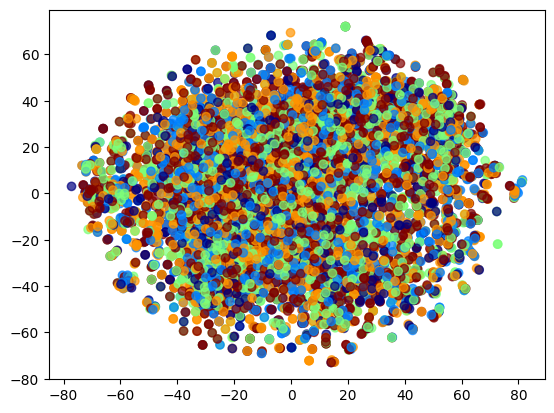

In [ ]:
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1],
            c=labels, cmap='jet', alpha=0.7)

plt.show()

# **EXERCISE 2**

Graph Convolutional Network Model

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = SAGEConv((-1, -1), 64)
        self.conv2 = SAGEConv((-1, -1), 128)

        self.linear1 = Linear(128, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).tanh()
        x = dropout(x, p=0.3)

        x = self.conv2(x, edge_index).tanh()
        x = dropout(x, p=0.3)

        x = self.linear1(x)

        return x

Function for training GCN model

In [ ]:
def train_gcn(model, dataset, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(dataset.x, dataset.edge_index)
        loss = criterion(out[dataset.train_mask],
                         dataset.y[dataset.train_mask])
        loss.backward()
        optimizer.step()

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
model2 = GCN(num_classes=10)

optimizer = Adam(model2.parameters(), lr=0.0001)

criterion = CrossEntropyLoss()

Visualization before training

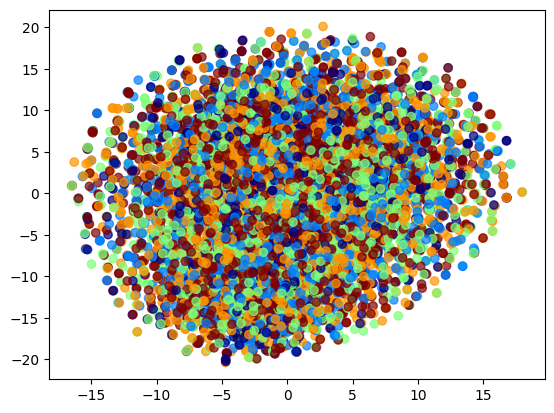

In [ ]:
node_embeddings_gcn = model2(dataset.x, dataset.edge_index)
node_embeddings_gcn = model().detach().cpu().numpy()

tsne = TSNE(n_components=2)
node_embeddings_gcn_2d = tsne.fit_transform(node_embeddings_gcn)

plt.scatter(node_embeddings_gcn_2d[:, 0], node_embeddings_gcn_2d[:, 1],
            c=labels, cmap='jet', alpha=0.7)

plt.show()

In [ ]:
train_gcn(model2, dataset, optimizer, criterion, 1)

IndexError: too many indices for tensor of dimension 1

Visualization after training

In [ ]:
node_embeddings_gcn_2 = model2(dataset.x, dataset.edge_index)
node_embeddings_gcn_2 = model().detach().cpu().numpy()
tsne = TSNE(n_components=2)
node_embeddings_2d_2 = tsne.fit_transform(node_embeddings_gcn_2)

plt.scatter(node_embeddings_2d_2[:, 0], node_embeddings_2d_2[:, 1],
            c=labels, cmap='jet', alpha=0.7)

plt.show()

GCN results

In [ ]:
print('GCN results:')
print(f'Accuracy: {accuracy_score(preds, test_y)}')
print(f'Precision: {precision_score(preds, test_y, average="micro")}')
print(f'Recall: {recall_score(preds, test_y, average="micro")}')
print(f'F1 score: {f1_score(preds, test_y, average="micro")}')